In [35]:
from pyspark.sql import SparkSession

In [36]:
spark = SparkSession.builder.appName("trip_count_by_zone_sql2").getOrCreate()

In [41]:
trip_files = "/Users/keon/fastcampus/data-engineering/01-spark/data/trips/*"
zone_file = "/Users/keon/fastcampus/data-engineering/01-spark/data/taxi+_zone_lookup.csv"

In [55]:
trips_df = spark.read.csv(f"file:///{trip_files}", inferSchema = True, header = True)
zones_df = spark.read.csv(f"file:///{zone_file}", inferSchema = True, header = True)
# trip_data = spark.read.format("csv").option("header", "true").load(trip_files)

In [56]:
trips_df.printSchema()
zones_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [58]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zones")

In [131]:
query = """
    SELECT 
        t.VendorID as vendor_id,
        TO_DATE(t.tpep_pickup_datetime) as pickup_date,
        TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
        HOUR(t.tpep_pickup_datetime) as pickup_time,
        HOUR(t.tpep_dropoff_datetime) as dropoff_time,
        t.trip_distance,
        t.RatecodeID as rate_code,
        t.store_and_fwd_flag,
        t.fare_amount,
        t.tip_amount,
        t.tolls_amount,
        t.total_amount,
        t.payment_type,
        t.passenger_count,
        t.PULocationID as pickup_location_id,
        pz.Zone as pickup_zone,
        t.DOLocationID as dropoff_location_id,
        dz.Zone as dropoff_zone
    FROM 
        trips t
    LEFT JOIN
        zones pz
        ON
            t.PULocationID = pz.LocationID
    LEFT JOIN
        zones dz
        ON
            t.DOLocationID = dz.LocationID
"""
combo_df = spark.sql(query)
combo_df.createOrReplaceTempView("combo")

In [132]:
combo_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [142]:
spark.sql("SELECT pickup_date, pickup_time from combo WHERE pickup_time > 0").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
| 2021-01-01|         15|
+-----------+-----------+
only showing top 20 rows



# Check Data

In [73]:
combo_df.select("total_amount").describe().toPandas()

,summary,total_amount
0,count,15000700
1,mean,18.75545205706905
2,stddev,145.74424528059743
3,min,-647.8
4,max,398469.2


In [74]:
combo_df.select("trip_distance").describe().toPandas()

,summary,trip_distance
0,count,15000700
1,mean,6.628629402627825
2,stddev,671.7293482115845
3,min,0.0
4,max,332541.19


In [75]:
combo_df.select("passenger_count").describe().toPandas()

,summary,passenger_count
0,count,14166672
1,mean,1.4253783104458126
2,stddev,1.0443270490596768
3,min,0
4,max,9


In [100]:
query = """
SELECT
    DATE_TRUNC('MM', c.pickup_date) AS date_month,
    COUNT(*) as trips
FROM
    combo c
WHERE
    pickup_date <= '2020-12-31' or
    pickup_date >= '2021-08-01'
GROUP BY
    date_month
"""

spark.sql(query).show()

+-------------------+-----+
|         date_month|trips|
+-------------------+-----+
|2009-01-01 00:00:00|  111|
|2008-12-01 00:00:00|   26|
|2020-12-01 00:00:00|   16|
|2021-08-01 00:00:00|   36|
|2021-12-01 00:00:00|    5|
|2021-09-01 00:00:00|    3|
|2021-11-01 00:00:00|    5|
|2029-05-01 00:00:00|    1|
|2004-04-01 00:00:00|    1|
|2021-10-01 00:00:00|    3|
|2002-12-01 00:00:00|    1|
|2003-01-01 00:00:00|    1|
+-------------------+-----+



# Data Cleaning

In [143]:
query = """
SELECT
    *
FROM
    combo c
WHERE 
    c.total_amount < 10000
    AND c.total_amount > 0
    AND c.trip_distance < 1000
    AND c.passenger_count < 100
    AND c.pickup_date >= '2021-01-01'
    AND c.pickup_date < '2021-08-01'
"""
combo_df = spark.sql(query)
combo_df.createOrReplaceTempView("imputed_combo")

# Simple EDA

In [125]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [126]:
query = """
SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    COUNT(*) AS trips
FROM
    imputed_combo c
GROUP BY
    c.pickup_date,
    day_of_week
"""

pd_df = spark.sql(query).toPandas()

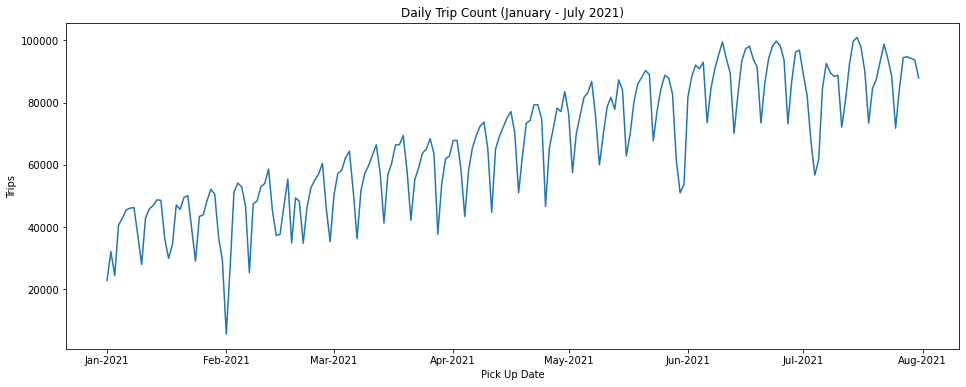

In [127]:
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x='pickup_date', y='trips', data=pd_df, ax=ax)

ax.set_title("Daily Trip Count (January - July 2021)")
ax.set_ylabel("Trips")
ax.set_xlabel("Pick Up Date")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))

plt.show()

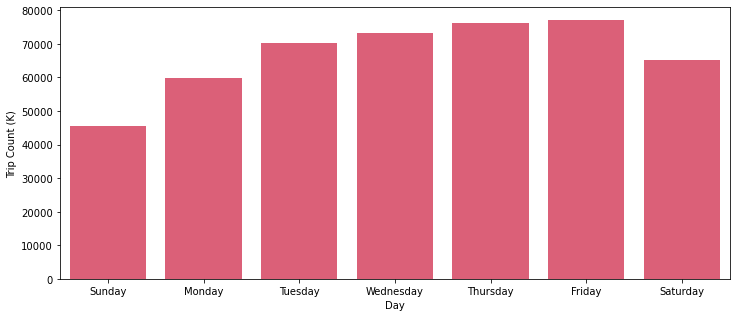

In [128]:
data = pd_df.groupby("day_of_week").trips.median().to_frame().reset_index()

data["sort_dow"] = data["day_of_week"].replace({"Sunday":0, 
                                                "Monday":1,
                                                "Tuesday":2,
                                                "Wednesday":3,
                                                "Thursday":4,
                                                "Friday": 5,
                                                "Saturday":6})

data.sort_values(by="sort_dow", inplace=True)

fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x="day_of_week",
            y="trips",
            palette=["#f04b6b"],
            data=data,
            dodge=False, ax=ax)

ax.set_ylabel("Trip Count (K)")
ax.set_xlabel("Day")

plt.show()

In [157]:
# 시간별 택시 이용
def get_weekday(date):
    import calendar 
    return calendar.day_name[date.weekday()]

spark.udf.register('get_weekday', get_weekday)


query = """
SELECT
    c.pickup_date,
    get_weekday(c.pickup_date) AS day_of_week,
    COUNT(*) AS trips
FROM
    imputed_combo c
GROUP BY
    c.pickup_date,
    day_of_week
"""

pd_df = spark.sql(query).toPandas()

In [176]:
# payments
def parse_payment_type(payment_type):
    payment_type_to_string = {
        1: "Credit Card",
        2: "Cash",
        3: "No Charge",
        4: "Dispute",
        5: "Unknown",
        6: "Voided Trip",
    }
    return payment_type_to_string[payment_type]

spark.udf.register('parse_payment_type', parse_payment_type)
query = """
SELECT
    parse_payment_type(payment_type),
    COUNT(*) AS trips,
    0 AS pct_total_trip_count,
    ROUND(MEAN(c.fare_amount), 2) AS mean_fare_amount,
    ROUND(STD(c.fare_amount), 2) AS stdev_fare_amount
FROM
    imputed_combo c
GROUP BY 
    payment_type
"""

pd_df = spark.sql(query).toPandas()

In [177]:
pd_df['pct_total_trip_count'] = round((pd_df['trips']*100)/count, 2)
pd_df

,parse_payment_type(payment_type),trips,pct_total_trip_count,mean_fare_amount,stdev_fare_amount
0,Credit Card,10714696,76.02,12.22,11.04
1,No Charge,59235,0.42,11.98,15.08
2,Dispute,23889,0.17,12.73,14.88
3,Cash,3295930,23.39,12.03,13.17
4,Unknown,1,0.00,17.80,NaN
